In [340]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import mysql.connector

import sys
sys.path.insert(0,"/home/apprenant/PycharmProjects/FoodFlix")


In [341]:
#keep the data
df = pd.read_csv("../data/02_intermediate/intermediate.csv", sep=',', low_memory=False)

In [342]:
df

,product_name,energy_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition_grade_fr
0,Panés ou colin d'Alaska,837.0,18.5,0.8,11.4,0.244094,0.7,2.0,b
1,Condiment Balsamique Blanc,464.0,22.0,0.0,0.5,0.003937,0.0,5.0,c
2,Petit beurre Monoprix bio,1890.0,20.0,NaN,6.0,0.394000,10.0,22.0,e
3,Cornichons aigres-doux,144.0,4.0,1.7,1.1,0.492126,0.0,-2.0,a
4,Guacamole Épicé,788.0,1.1,4.6,1.7,0.409449,3.7,3.0,c
...,...,...,...,...,...,...,...,...,...
29530,Salami Milano,1406.0,0.5,0.0,21.0,1.574803,9.8,23.0,e
29531,Yaourt nature maigre 0% MG,153.0,4.5,NaN,4.3,0.050000,NaN,NaN,NaN
29532,Maïs Bio,334.0,5.2,3.8,2.9,0.157480,0.5,-9.0,a
29533,Petits Pains Grillés Blé Complet,1599.0,3.5,8.0,11.3,0.598425,0.5,0.0,b


In [343]:
#the save to csv add an index, I drop it
df.columns


Index(['product_name', 'energy_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g', 'saturated-fat_100g',
       'nutrition-score-fr_100g', 'nutrition_grade_fr'],
      dtype='object')

# 1. Traitement des Doublons

## 2.1 recherche des doublons

In [344]:
print(df.duplicated().value_counts())
df.shape

False    29166
True       369
dtype: int64


(29535, 9)

## II.2 Traitement des doublons

In [345]:
df.drop_duplicates(keep='last',inplace=True)
print(df[df.duplicated(keep=False)])
df.shape

Empty DataFrame
Columns: [product_name, energy_100g, sugars_100g, fiber_100g, proteins_100g, sodium_100g, saturated-fat_100g, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []


(29166, 9)

# 2. Traitement des valeurs manquantes

In [346]:
#recherche des valeurs manquantes:

print(df.isna().sum())
print(df.shape)

product_name                   0
energy_100g                 3926
sugars_100g                 4403
fiber_100g                 12165
proteins_100g               3988
sodium_100g                 4398
saturated-fat_100g          4415
nutrition-score-fr_100g     4800
nutrition_grade_fr          4800
dtype: int64
(29166, 9)


comme il s'agit ici de calculer un score, je remplace toutes les valeurs Nan par zéro.

In [347]:
df = df.fillna(0)

In [348]:
print(df.isna().sum())
print(df.shape)

product_name               0
energy_100g                0
sugars_100g                0
fiber_100g                 0
proteins_100g              0
sodium_100g                0
saturated-fat_100g         0
nutrition-score-fr_100g    0
nutrition_grade_fr         0
dtype: int64
(29166, 9)


on constate que les Nan ont bien été modifiées.

# 3.Consistance, reformatage et valeurs abbérantes.

## 3.1 Evaluer la consistance des variables de type caractère.

#### Afficher l'ensemble des valeurs uniques

In [349]:
df["product_name"].value_counts()

Mayonnaise                                                  22
Huile d'olive vierge extra                                  16
Mozzarella                                                  15
Spaghetti                                                   15
Coquillettes                                                14
                                                            ..
Miel Forêt et Sapin                                          1
Bûche glacée, caramel-vanille-pécan                          1
Huile d'olive vierge extra au piment                         1
Les glaces façon Panna Cotta sauce caramel à l'italienne     1
Beurre de Bretagne demi-sel                                  1
Name: product_name, Length: 26397, dtype: int64

pour les produits sur-représentés il convient de vérifier quelle valeur est la bonne

Il y a 22 occurence de mayonnaise, je vais donc les remplacer par une seule qui aura pour valeur la moyenne des 22 autres produits.

In [352]:

df = df.groupby('product_name').agg({'energy_100g':'mean',
                                     'sugars_100g':'mean',
                                     'fiber_100g':'mean',
                                     'proteins_100g':'mean',
                                     'sodium_100g':'mean',
                                     'saturated-fat_100g':'mean',
                                     'nutrition-score-fr_100g':'mean',
                                     'nutrition_grade_fr':'first'
                                     })

#check
df


,energy_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition_grade_fr
product_name,,,,,,,,
bière blonde pur malt,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0
18 marrons glacés,1378.0,56.00,4.80,0.80,0.019700,0.10,9.0,c
Boulettes à la Marocaine et légumes,393.0,2.00,0.50,5.10,0.157480,1.10,0.0,b
Confiture allégée abricot,696.0,40.00,0.00,0.50,0.011811,0.10,9.0,c
Crac noisettes,2716.0,9.77,8.23,14.92,0.708661,7.49,19.0,e
...,...,...,...,...,...,...,...,...
œufs,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0
œufs frais de poules élevées en plein air issus de l'agriculture biologique,586.0,0.70,0.00,12.00,0.125984,2.70,-1.0,a
Семечки жареные Отборные соленые,2456.0,0.00,0.00,24.00,0.000000,0.00,0.0,0


## 3.2 Evaluer la consistance des variables de type numérique

#### Afficher la distribution d'une variable numérique

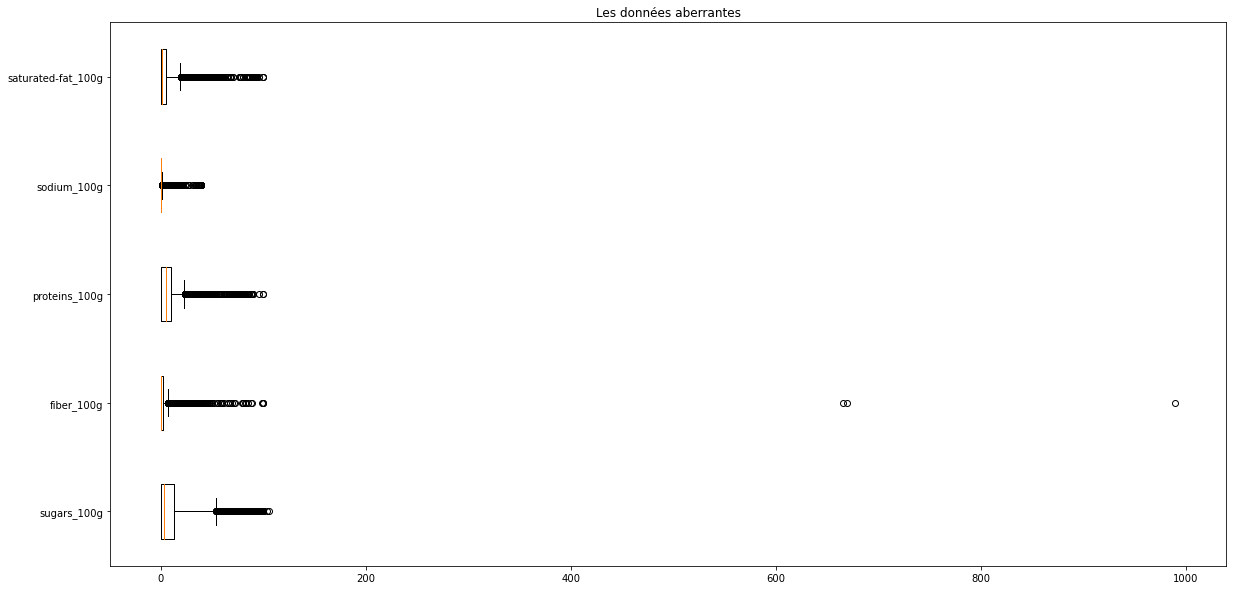

In [102]:
data = [df['sugars_100g'], df['fiber_100g'], df['proteins_100g'],df['sodium_100g'],df['saturated-fat_100g']]
plt.figure(figsize = (20,10))
ax = plt.boxplot(data, whis=[5,95], vert=False)


plt.title('Les données aberrantes')
plt.yticks([1, 2, 3,4,5], ['sugars_100g', 'fiber_100g', 'proteins_100g','sodium_100g','saturated-fat_100g' ])

plt.show()   

il s'agit de valeurs quantitatif pour 100g de produit ces valeurs ne peuvent donc ni etre négatives ni supérieures à 100

In [103]:
columns=['sugars_100g','fiber_100g','proteins_100g','sodium_100g','saturated-fat_100g']

for col in columns:
    df.loc[df[col]> 100, col] = 0
    

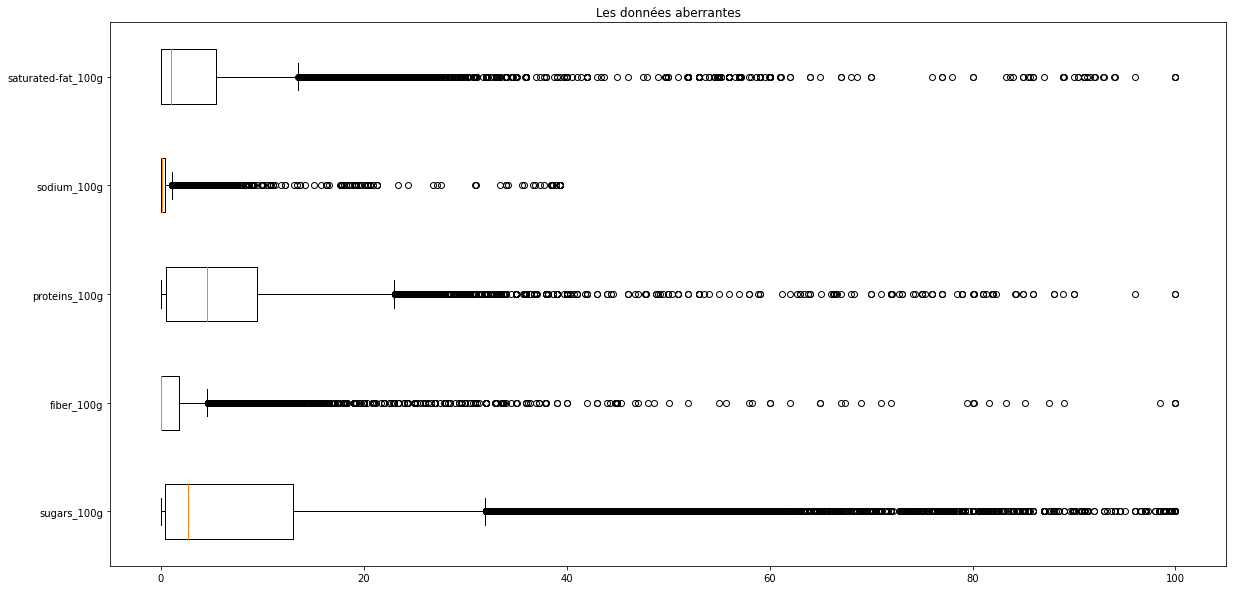

In [105]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(data, vert=False)


plt.title('Les données aberrantes')
plt.yticks([1, 2, 3,4,5], ['sugars_100g', 'fiber_100g', 'proteins_100g','sodium_100g','saturated-fat_100g' ])

plt.show()   

#### Traiter les valeurs impossibles

l'énergie d'un aliment ne peut pas être supérieure à 4000KJ (notion métier)

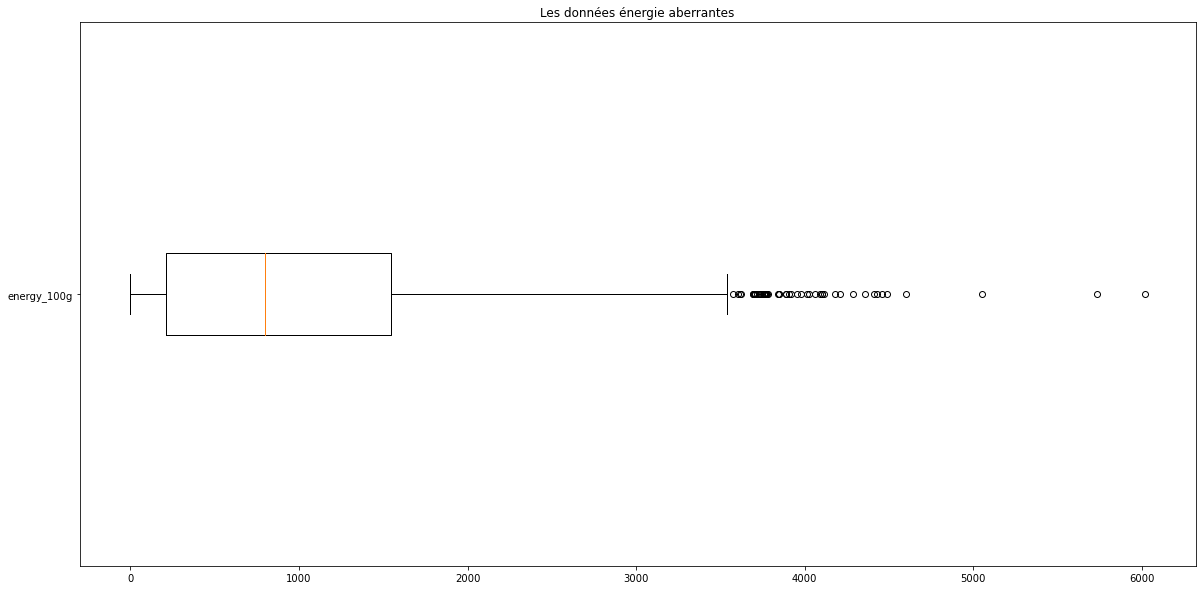

In [107]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(df['energy_100g'], vert=False)

plt.title('Les données énergie aberrantes')
plt.yticks([1], ['energy_100g' ])

plt.show()   

In [108]:
df = df[df['energy_100g']<4000]

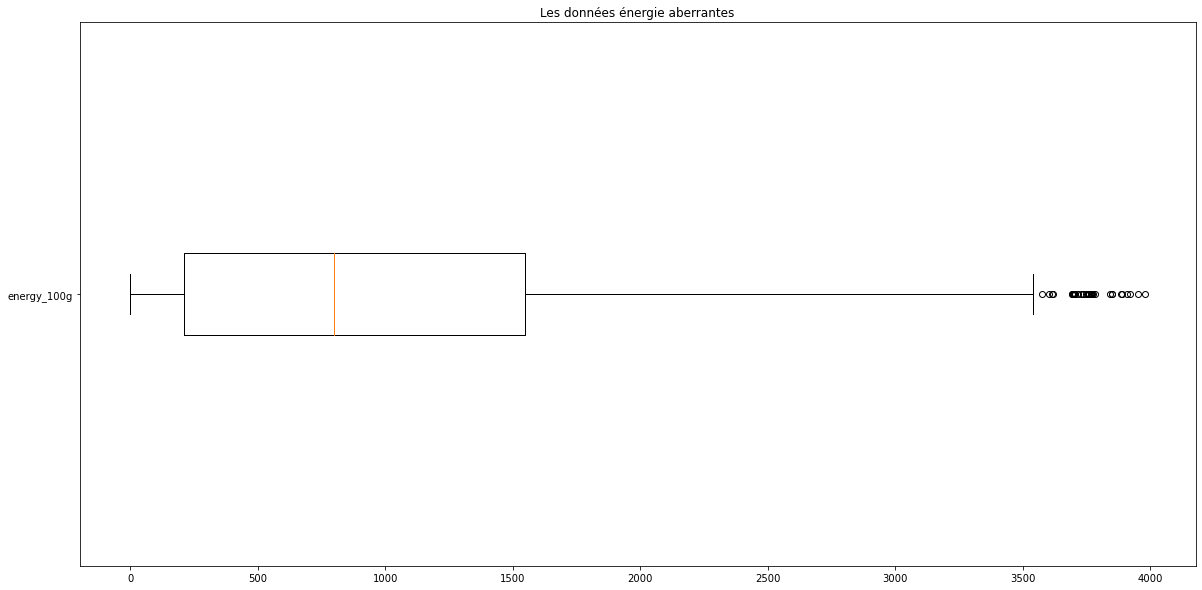

In [109]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(df['energy_100g'], vert=False)

plt.title('Les données énergie aberrantes')
plt.yticks([1], ['energy_100g' ])

plt.show()   

# sauvegarde du jeu de données nettoyées

In [ ]:
df.to_csv("../data/02_intermediate/final.csv")